# Reinforcement Learning

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/300px-Reinforcement_learning_diagram.svg.png).

## Introduction

Reinforcement Learning is a special form of machine learning, where an agent interacts with an environment, receives observations on the effects of actions and collects rewards.

The goal of reinforcement learning is to learn an optimal policy, so that given a state an agent is able to decide what it should do next.

In this exercise we will look into three fundamental algorithms that are capable of solving MDPs, namely [Policy Iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Policy_iteration), [Value Iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Value_iteration), and [Q-Learning](https://en.wikipedia.org/wiki/Q-learning).

## Objectives

By the time you complete this lab, you should know:

- The relevant pieces for a reinforcement learning system
- The basics of *[gymnasium](https://gymnasium.farama.org/)* to conduct your own RL experiments
- Why Policy Iteration can be slower than Value Iteration
- The differences of value and policy iteration compared to Q-Learning
- How Q-Learning converges towards a stable policy
    - Some optional extensions to Q-Learning

## MDP

A Markov decision process is a 5-tuple $(\mathcal{S},\mathcal{A},p,r,\gamma)$

![MPD](mdp.png "MDP")

## Problem

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. (However, the ice is slippery, so you won't always move in the direction you intend.)

## Setup

To begin we'll need to install all the required python package dependencies.



In [1]:
#%pip install --quiet gymnasium

### Imports and Helper Functions

#### Imports

In [2]:
# Python imports
import random
import heapq
import collections

# Reinforcement Learning environments
import gymnasium as gym
# Scientific computing
import numpy as np
# Plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm


#### Helper Functions

In [3]:
# Define the default figure size
plt.rcParams['figure.figsize'] = [20, 5]

def create_numerical_map(env):
    """Convert the string map of the environment to a numerical version"""
    numerical_map = np.zeros(env.unwrapped.desc.shape)
    for i, row in enumerate(env.unwrapped.desc):
        for j, col in enumerate(row):
            if col.decode('UTF-8') == 'S': # Start
                numerical_map[i, j] = 0
            elif col.decode('UTF-8') == 'G': # Goal
                numerical_map[i, j] = 1
            elif col.decode('UTF-8') == 'F': # Frozen
                numerical_map[i, j] = 2
            elif col.decode('UTF-8') == 'H': # Hole
                numerical_map[i, j] = 3
    return numerical_map

def get_text_color(cell):
    c = cell.decode('UTF-8')
    if c == 'S' or c == 'H':
         return "white"
    else:
         return "black"

def visualize_rgb_array(ax, rgb_array):
    # Hide grid lines
    ax.grid(False)
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(rgb_array)

def visualize_env(env):
    """Plot the environment"""
    fig, ax = plt.subplots()
    # Hide grid lines
    ax.grid(False)
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('The frozen Lake')
    i = ax.imshow(create_numerical_map(env), cmap=cm.jet)
    plt.show()
    print('the start is blue, holes are red, ice is yellow and the goal is teal')

def visualize_policy(env, policy, ax=None, title=None):
    """Plot the policy in the environment"""
    if ax is None:
        ax = plt.gca()
    font_size = 10 if env.observation_space.n > 16 else 20
    
    for i, row in enumerate(env.unwrapped.desc):
        for j, col in enumerate(row):
            s = i * env.unwrapped.desc.shape[0]+j
            color = get_text_color(col)
            if policy[s] == 0:
                ax.annotate("L", xy=(j, i), xytext=(j, i), ha="center",
                            va="center", size=font_size, color=color)
            elif policy[s] == 1:
                ax.annotate("D", xy=(j, i), xytext=(j, i), ha="center",
                            va="center", size=font_size, color=color)
            elif policy[s] == 2:
                ax.annotate("R", xy=(j, i), xytext=(j, i), ha="center",
                            va="center", size=font_size, color=color)
            elif policy[s] == 3:
                ax.annotate("U", xy=(j, i), xytext=(j, i), ha="center",
                            va="center", size=font_size, color=color)

    # Hide grid lines
    ax.grid(False)
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if title is None:
        ax.set_title('Policy for the Frozen Lake')
    else:
        ax.set_title(title)
    ax.imshow(create_numerical_map(env), cmap=cm.jet)
    return


def visualize_v(env, v, ax=None, title=None):
    """Plot value function values in the environment"""
    if ax is None:
        ax = plt.gca()
    font_size = 10 if env.observation_space.n > 16 else 15
    for i, row in enumerate(env.unwrapped.desc):
        for j, col in enumerate(row):
            s = i * env.unwrapped.desc.shape[0]+j
            color = get_text_color(col)
            ax.annotate("{:.2f}".format(v[s]), xy=(j, i), xytext=(j, i), ha="center",
                        va="center", size=font_size, color=color)

    # Hide grid lines
    ax.grid(False)
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if title is None:
        ax.set_title('State Value Function for the Frozen Lake')
    else:
        ax.set_title(title)
    ax.imshow(create_numerical_map(env), cmap=cm.jet)
    return


def compute_max_v_from_q(env, q):
    """Compute the v function given the q function, maximizing over the actions of a given state."""
    v = np.zeros(env.observation_space.n)
    for i, row in enumerate(env.unwrapped.desc):
        for j, col in enumerate(row):
            s = i * env.unwrapped.desc.shape[0] + j
            v[s] = np.max(q[s, :])
    return v

def compute_greedy_policy_from_q(env, q):
    """Compute the greedy policy function given the q function, finding the action that yields the maximum of a given state."""
    policy = np.zeros(env.observation_space.n)
    for i, row in enumerate(env.unwrapped.desc):
        for j, col in enumerate(row):
            s = i * env.unwrapped.desc.shape[0] + j
            policy[s] = np.argmax(q[s, :])
    return policy

#### Deterministic Environments

In [4]:
# register variants of the frozen lake without execution uncertainty i.e. deterministic environments
from gymnasium.envs.registration import register

register(
    id='FrozenLakeNotSlippery-v1',
    entry_point='gymnasium.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78,  # optimum = .8196
)

register(
    id='FrozenLakeNotSlippery8x8-v1',
    entry_point='gymnasium.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '8x8', 'is_slippery': False},
    max_episode_steps=200,
    reward_threshold=0.99,  # optimum = 1
)

#### Policy Evaluation

In [5]:
def evaluate_episode(env, policy, discount_factor):
    """Evaluates a policy by running it until termination and collect its rewards"""
    state, _ = env.reset()
    total_return = 0
    step = 0
    while True:
        next_state, reward, term, trunc, _ = env.step(int(policy[state]))
        # term: terminated
        # trunc: truncated

        # Calculate the total
        total_return += (discount_factor ** step * reward)
        step += 1
        state = next_state
        if term or trunc:
            break
    return total_return


def evaluate_policy(env, policy, discount_factor=0.95, number_episodes=1000):
    """ Evaluates a policy by running it 'number_episodes' times"""
    return np.mean([evaluate_episode(env, policy, discount_factor) for _ in range(number_episodes)])

#### Policy and Value Iteraton Parameters

In [6]:
# Set parameters
max_iterations = 1000
num_episodes = 100
discount_factor = 0.95

### Environment

In [7]:
# Deterministic environments
env_name = 'FrozenLakeNotSlippery-v1'
# env_name = 'FrozenLakeNotSlippery8x8-v1'

# Stochastic environments
# env_name = 'FrozenLake-v1'
# env_name = 'FrozenLake8x8-v1'

Create the environment with the previously selected name

Generated the frozen lake with config: FrozenLakeNotSlippery-v1


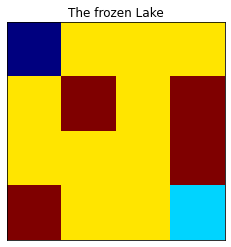

the start is blue, holes are red, ice is yellow and the goal is teal


In [8]:
env = gym.make(env_name, render_mode="rgb_array")
print('Generated the frozen lake with config: ' + env_name)
visualize_env(env)

#### Understanding the Environment (Object)

**TASK :**
Analyze the environment object and figure out its *observation-* and *actionspace* as well as its *reward range*.

What is the size of the observation space?

In [9]:
env.observation_space

Discrete(16)

The observation is a value representing the player’s current position as `current_row * nrows + current_col` (where both the row and col start at 0).

What is the size of the action space?

In [10]:
env.action_space

Discrete(4)

Four discrete actions indicating which direction to move the player:
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

What is the range of rewards?

In [11]:
env.unwrapped.reward_range

(0, 1)

Only a reward of +1 for reaching the goal and 0 otherwise.

### Uncertainty in Execution

the initial state is: 0
executing action 1, should go down
new state is: 4 terminated: False
executing action 3, should go up
new state is: 0 terminated: False
executing action 2, should go right
new state is: 1 terminated: False
executing action 0, should go left
new state is: 0 terminated: False


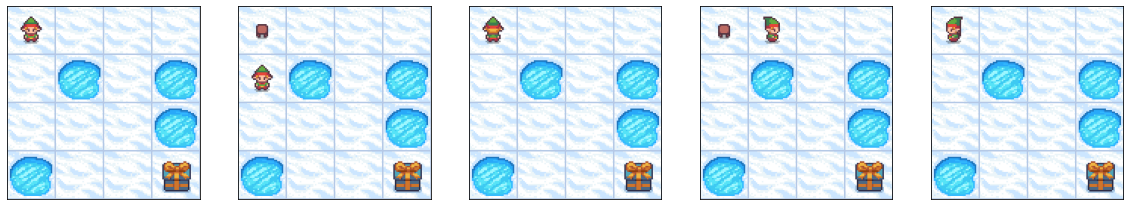

In [12]:
fig, ax = plt.subplots(1,5, figsize=(20,10))

s, _ = env.reset()
print("the initial state is: {}".format(s))
visualize_rgb_array(ax[0], env.render())

# The agent should go down
print("executing action 1, should go down")
s1, r, term, trunc, _ = env.step(1)
print("new state is: {} terminated: {}".format(s1, term))
visualize_rgb_array(ax[1], env.render())

# The agent should go up
print("executing action 3, should go up")
s1, r, term, trunc, _ = env.step(3)
print("new state is: {} terminated: {}".format(s1, term))
visualize_rgb_array(ax[2], env.render())

# The agent should go right
print("executing action 2, should go right")
s1, r, term, trunc, _ = env.step(2)
print("new state is: {} terminated: {}".format(s1, term))
visualize_rgb_array(ax[3], env.render())

# The agent should go left
print("executing action 0, should go left")
s1, r, term, trunc, _ = env.step(0)
print("new state is: {} terminated: {}".format(s1, term))
visualize_rgb_array(ax[4], env.render())

## Policy Evaluation

In [13]:
def policy_evaluation(policy, env, discount_factor, mode):
    """ Iteratively evaluate the value function under the given policy"""
    # Initialize the state value function
    v = np.zeros(env.observation_space.n)
    iteration = 0
    while True:
        iteration += 1
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            if mode == "policy_iteration":
                v[s] = evaluate_action(s, v, prev_v, policy, env, discount_factor)
            elif mode == "value_iteration":
                v[s] = evaluate_max_action(s, v, prev_v, env, discount_factor)
        if (np.sum((np.fabs(prev_v - v))) <= 1e-4):
            break
    return v, iteration

def evaluate_action(s, v, prev_v, policy, env, discount_factor):
    # Retrieve the action under the current policy
    a = policy[s]
    expected_reward = 0
    expected_discounted_return = 0
    # Calculate the expected reward and the expected discounted return | p = probability
    for p, s1, r, _ in env.unwrapped.P[s][a]:
        ### TASK: define the expected_reward and the expected_discounted_return
        expected_reward += p*r
        expected_discounted_return += discount_factor*p*prev_v[s1]
    # Calculate the V-Value
    return expected_reward + expected_discounted_return


def evaluate_max_action(s, v, prev_v, env, discount_factor):
    # Initialize the action value function
    q = np.zeros([env.observation_space.n, env.action_space.n])
    # Iterate over each action
    for a in range(env.action_space.n):
        expected_reward = 0
        expected_discounted_return = 0
        # Calculate the expected reward and the expected discounted return | p = probability
        for p, s1, r, _ in env.unwrapped.P[s][a]:
            ### TASK: define the expected_reward and the expected_discounted_return
            expected_reward += p*r
            expected_discounted_return += discount_factor*p*prev_v[s1]
        # Calculate the Q-Value
        q[s, a] = expected_reward + expected_discounted_return
    ### TASK: define the value function and the policy with respect to q
    # Choose the max q value over all actions
    return np.max(q[s, :])

## Policy Improvement

In [14]:
def policy_improvement(v, policy, env, discount_factor):
    """ Improve the policy given a value-function """
    # Initialize the policy
    policy = np.zeros(env.observation_space.n)
    # Initialize the action value function
    q = np.zeros([env.observation_space.n, env.action_space.n])
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            q[s,a] = np.sum([p * (r + discount_factor * v[s1]) for p, s1, r, _ in  env.unwrapped.P[s][a]])
        policy[s] = np.argmax(q[s,:])
    return policy

## Policy Iteration
![Policy Iteration](policy_iteration.png "Policy Iteration")

### Algorithm

**TASK :**
Add the missing steps for the policy iteration algorithm.

In [15]:
def policy_iteration(env, discount_factor, max_iterations):
    """ Policy-Iteration algorithm """
    # Initialize the policy
    policy = np.zeros(env.observation_space.n)
    for i in range(max_iterations):
        # TASK: evaluate the current policy
        v, iteration = policy_evaluation(policy, env, discount_factor, "policy_iteration")
        # TASK: define the new policy
        new_policy = policy_improvement(v, policy, env, discount_factor)
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at iteration #{:d}'.format((i)))
            break
        # Plot the current policy
        title_p = 'Policy Improvement #{:d}'.format((i+1))
        title_v = '#Policy Evaluations {:d}'.format(iteration)
        fig, ax = plt.subplots(1,2)
        visualize_v(env, v, ax[0], title_v)
        visualize_policy(env, new_policy, ax[1], title_p)
        policy = new_policy
    return policy, v

Run the algorithm and evaluate the result.

Policy-Iteration converged at iteration #6
Average return of the policy: 0.77


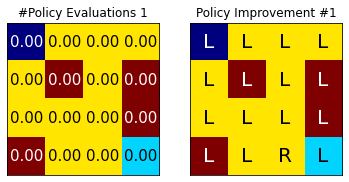

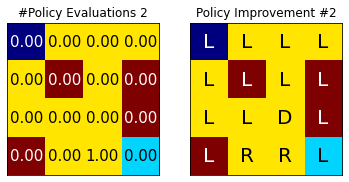

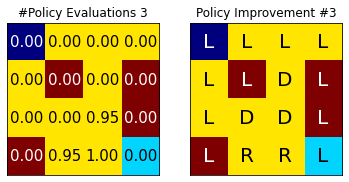

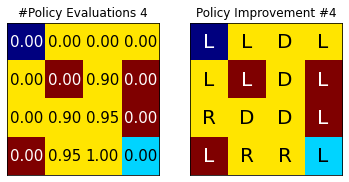

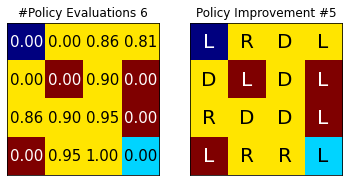

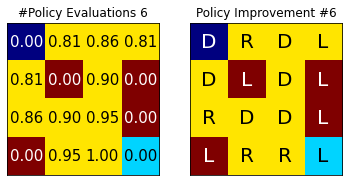

In [16]:
# Determine the optimal value function and policy given the model of the environment
policy_opt, v_opt = policy_iteration(env, discount_factor, 1000)

# Evalutate the found value function and policy given the model of the environment
policy_return = evaluate_policy(env, policy_opt, discount_factor, num_episodes)
print('Average return of the policy: {:.2f}'.format(policy_return))

## Value Iteration

![Value Iteration](value_iteration.png "Value Iteration")


### Algorithm
**TASK :**
Add the missing calculations for the *expected_reward*, the *expected_discounted_return*, *v[s]* and *policy[s]*.

In [17]:
def value_iteration(env, discount_factor, max_iterations):
    """ Value-Iteration algorithm """
    # Initialize the policy
    policy = np.zeros(env.observation_space.n)
    for i in range(max_iterations):
        # TASK: evaluate the current policy
        v, iteration = policy_evaluation(policy, env, discount_factor, "value_iteration")
        # TASK: define the new policy
        new_policy = policy_improvement(v, policy, env, discount_factor)
        if (np.all(policy == new_policy)):
            print ('Value-Iteration converged at iteration #{:d}'.format((i)))
            break
        # Plot the current policy
        title_p = 'Policy Improvement #{:d}'.format((i+1))
        title_v = '#Policy Evaluations {:d}'.format(iteration)
        fig, ax = plt.subplots(1,2)
        visualize_v(env, v, ax[0], title_v)
        visualize_policy(env, new_policy, ax[1], title_p)
        policy = new_policy
    return policy, v

Run the algorithm and evaluate the result.

Value-Iteration converged at iteration #1
Average return of the policy: 0.77


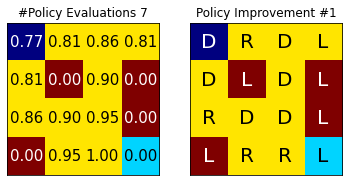

In [18]:
# Determine the optimal value function and policy given the model of the environment
policy_opt, v_opt = value_iteration(env, discount_factor, 1000)

# Evalutate the found value function and policy given the model of the environment
policy_return = evaluate_policy(env, policy_opt, discount_factor, num_episodes)
print('Average return of the policy: {:.2f}'.format(policy_return))

## Q-Learning

![Q-Learning](q_learning.png "Q-Learning")

### Temporal Difference Error
### $\delta_t = \underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{\tilde{a} \in \mathcal{A}}Q(s_{t+1}, \tilde{a})}_{\text{estimate of optimal future value}} - \underbrace{Q(s_{t}, a_{t})}_{\text{estimate of optimal current value}}$

### Temporal Difference Update
### $Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot \underbrace{\delta_t}_\text{temporal difference error}$

### Transiton Tuple
For ease of use we define a transition tuple that allows us to combine all the relevant information from one state to another.

In [19]:
# p = priority (only needed for (prioritized) experience replay)
# s = state
# a = action
# s1 = successor state
# r = reward
# td_e = temporal difference error
Transition = collections.namedtuple('Transition', ('p', 's', 'a', 's1', 'r', 'td_e'))

### Replay Memory and Prioritized Experience Replay (optional)

Experience Replay and prioritization of specific experiences are common techniques to make the training more data efficient.

* [Paper - Experience Replay, 1992](https://link.springer.com/content/pdf/10.1007%2FBF00992699.pdf)
* [Paper - Prioritized Experience Replay, 2015](https://arxiv.org/abs/1511.05952)

In [20]:
class ReplayMemory():
    def __init__(self, config):
        # transitions memory
        self.transitions = []
        # size of the memory
        self.memory_size = config.memory_size
        # size of the batches
        self.batch_size = config.batch_size
        # flag for prioritized experience replay
        self.prioritized = config.prioritized
        
    def push(self, transition):
        # if the memory is not yet full, add the new transition
        if len(self.transitions) < self.memory_size:
            heapq.heappush(self.transitions, transition)
        # if the memory is full, remove the smallest transition and add the new transition 
        else:
            del self.transitions[-1]
            heapq.heappush(self.transitions, transition)
    
    def replay(self, batch_size):
        if self.prioritized:
            return heapq.nsmallest(self.batch_size,self.transitions)
        else: 
            return random.sample(sorted(self.transitions),self.batch_size)
    
    def __len__(self):
        return len(self.transitions)    

### The Q Agent
So far we have only defined simple function calls with
```python
def function_name(arg1, arg2):
    # compute something with arg1 and arg2 and return something
    if arg2 > 0:
        something = other_function(arg1) - arg2
    else:
        something = arg1
    return something
```
However for more complex tasks it is advisable to write object oriented code using classes. Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state. Class instances can also have methods (defined by its class) for modifying its state.



Hence we create a class **QAgent** that incorporates all the methods needed for Q-Learning.

```python
class QAgent:
    
    def __init__(self): # constructor that gets called when the object is being created
        
    def td_error(self): # Temporal Difference Error
        
    def td_update(self): # Temporal Difference Update
    
    def train(self, env): # Train the agent     
```

**TASK :**
Add the missing formulars for the TD-error and the TD-update.

In [21]:
class QAgent:
    def __init__(self, config):
        # Maximum length of training
        self.training_length = config.training_length
        # Maximum length of an episode 
        self.episode_length = config.episode_length
        # TD error update step size
        self.learning_rate = config.learning_rate
        # Discount factor
        self.discount_factor = config.discount_factor
        # Enabling experience replay
        self.replay_memory_enabled = True if config.config_replay_memory else False
        # Initialize the replay memory of the agent
        if self.replay_memory_enabled:
            self.replay_memory = ReplayMemory(config.config_replay_memory)
        
    def td_error(self, q, q_target, s, a, s1, r):
        # TASK: return the TD-Error
        # Calculates the temporal difference error given the current model and transition
        td_e = r + self.discount_factor*np.max(q_target[s1, :]) - q[s, a]
        return td_e
    
    def td_update(self, q, t):
        # TASK: return the update for the q value
        # Calculates the adjusted action value (q) given the td error from a single transition
        q = q + self.learning_rate * t.td_e
        return q

    def td_replay(self, q, q_target):
        # Use the replay memory to run additional updates
        if len(self.replay_memory) >= self.replay_memory.batch_size:
            for t in self.replay_memory.replay(self.replay_memory.batch_size):
                # Recalculate the temporal difference error for this transition
                td_e = self.td_error(q, q_target, t.s, t.a, t.s1, t.r)
                # Create an updated transition tuple
                updated_t = Transition(-td_e, t.s, t.a, t.s1, t.r, td_e)
                # Save the transition in replay memory
                self.replay_memory.push(updated_t)
                # Update model / q table
                q[t.s, t.a] = self.td_update(q[t.s, t.a], updated_t)
        return q
    
    def epsilon_greedy_noise(self, episode):
        epsilon = np.random.randn(1, env.action_space.n)*(1./(episode+1))
        a = np.argmax(self.q[s, :] + epsilon)
        return a, epsilon
    
    def epsilon_greedy_linear(self, env, episode):
        epsilon = (1-(episode+1)/self.training_length)
        if epsilon > np.random.rand():
            a = np.random.randint(env.action_space.n)
        else:
            a = np.argmax(self.q[s, :])
        return a, epsilon
    
    def train(self, env):
        # Initialize the model / q table with zeros/random
        self.q = np.zeros([env.observation_space.n, env.action_space.n])
        # Create a target model / q table
        self.q_target = self.q
        
        ### METRICS
        # create lists to contain various metrics that should be tracked during the training process
        self.metrics = {
            'return': np.zeros(self.training_length),
            'q_avg': np.zeros(self.training_length),
            'epsilon': np.zeros(self.training_length),
            'td_error': np.zeros(self.training_length)
        }
        
        for episode in range(self.training_length):
            # Reset the environment and retrieve the initial state
            s, _ = env.reset()
            # Set the 'terminated' and 'truncated' flags to false
            term, trunc = False, False
            # Set the step of the episode to 0
            step = 0
            # Start the Q-Learning algorithm
            while step < self.episode_length:
                # Derive action from current policy (epsilon_greedy noise)
                #a, epsilon = self.epsilon_greedy_linear(env, episode)
                a, epsilon = self.epsilon_greedy_noise(episode)
                

                # Execute the action and generate a succesor state as well as receive an immediate reward
                s1, r, term, trunc, _ = env.step(a)

                # Calculate the temporal difference error
                td_e = self.td_error(self.q, self.q_target, s, a, s1, r)

                # Create a transition tuple
                transition = Transition(-(td_e+0.001), s, a, s1, r, td_e)       

                # Save the transition in replay memory
                if self.replay_memory_enabled:
                    self.replay_memory.push(transition)

                # Update model / q table
                self.q[s, a] = self.td_update(self.q[s, a], transition)

                # Assign the current state the value of the successor state
                s = s1

                # Increment the step
                step += 1

                ### METRICS
                # Accumulate the episode return
                self.metrics['return'][episode] += self.discount_factor**step*r
                # Track the temporal difference error
                self.metrics['td_error'][episode] += td_e
                # Track the max epsilon values
                self.metrics['epsilon'][episode] += np.max(epsilon)
                # Track the average q values
                self.metrics['q_avg'][episode] = np.average(self.q)


                # If we reached a terminal state, abort the while loop, reset the environment, and start over
                if term or trunc or step == 100:

                    # At the end of the episode update the target model with the current model

                    # If experience replay is enabled, replay the experience collected so far
                    if self.replay_memory_enabled:
                        self.q_target = self.td_replay(self.q, self.q_target)
                    else:
                        self.q_target = self.q

                    ### METRICS
                    self.metrics['epsilon'][episode] /= step
                    self.metrics['q_avg'][episode] /= step
                    self.metrics['td_error'][episode] /= step
                    break

### Configuration Tuple
For ease of use we define a configuration tuple that allows us to combine all the relevant configuration from into one object.

In [22]:
ConfigQAgent = collections.namedtuple(
    "ConfigQAgent",
    (
        "learning_rate",
        "training_length",
        "episode_length",
        "discount_factor",
        "config_replay_memory",
    ),
)

ConfigReplayMemory = collections.namedtuple(
    "ConfigReplayMemory", ("memory_size", "batch_size", "prioritized")
)

### Configure and Train the Agent


In [23]:
# Agent 1
config_replay_memory = ConfigReplayMemory(500, 50, False)
config_q_agent = ConfigQAgent(0.1, 400, 50, discount_factor, None)

q_agent = QAgent(config_q_agent)
q_agent.train(env)
policy = compute_greedy_policy_from_q(env, q_agent.q_target)     

### Visualize Metrics

Average return: 0.77
Score over time: 0.004138030026575919


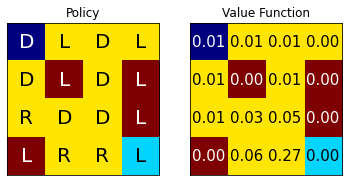

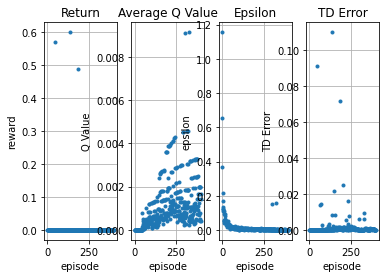

In [24]:
print('Average return: {:.2f}'.format(evaluate_policy(env, policy, q_agent.discount_factor, 1000)))
print("Score over time: " + str(sum(q_agent.metrics['return'])/q_agent.training_length))

fig, axi = plt.subplots(1, 2)
visualize_policy(env, policy, axi[0], title="Policy")
visualize_v(env, compute_max_v_from_q(env, q_agent.q_target),axi[1], title="Value Function")

fig, ax = plt.subplots(1, 4)
# Plot the return over time
ax[0].plot(range(q_agent.training_length), q_agent.metrics['return'], ".")
ax[0].set(xlabel='episode', ylabel='reward', title='Return')
ax[0].grid()

# Plot the Q value over time
ax[1].plot(range(q_agent.training_length), q_agent.metrics['q_avg'], ".")
ax[1].set(xlabel='episode', ylabel='Q Value', title='Average Q Value')
ax[1].grid()

# Plot the epsilon over time
ax[2].plot(range(q_agent.training_length), q_agent.metrics['epsilon'], ".")
ax[2].set(xlabel='episode', ylabel='epsilon', title='Epsilon')
ax[2].grid()

# Plot the td error over time
ax[3].plot(range(q_agent.training_length), q_agent.metrics['td_error'], ".")
ax[3].set(xlabel='episode', ylabel='TD Error', title='TD Error')
ax[3].grid()   

### Evaluate different Hyperparameters (optional)

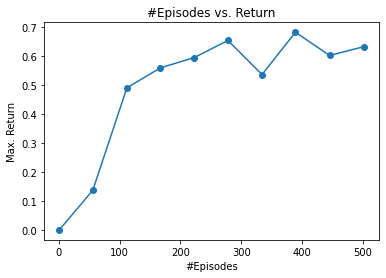

In [25]:
def evaluate_training_episodes(number_evaluation_points, number_evaluations):
    ### Evaluate different episode lengths
    training_lengths = np.linspace(1, 501, number_evaluation_points, dtype = int)
    returns = np.zeros(number_evaluation_points)
    for i in range(number_evaluation_points):
        config_q_agent = ConfigQAgent(0.1, training_lengths[i], 100, discount_factor, None)
        for j in range(number_evaluations):
            q_agent = QAgent(config_q_agent)
            q_agent.train(env)
            returns[i] += np.max(q_agent.metrics['return'])
        returns[i] /= number_evaluations

    fig, ax = plt.subplots()
    ax.set(xlabel='#Episodes', ylabel='Max. Return', title='#Episodes vs. Return')
    ax.plot(training_lengths, returns, '-o')
    
evaluate_training_episodes(10, 10)
